In [1]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        self.tik = time.time()
        
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.05517 sec'

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00050 sec'

# The normal distribution and squared loss

In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

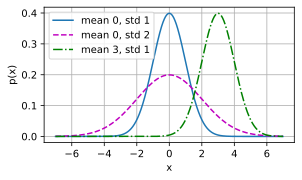

In [7]:
x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel = 'x', ylabel = 'p(x)'
        , figsize=(4.5, 2.5), legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [8]:
import random
import torch
from d2l import torch as d2l

In [9]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b 
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [10]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [11]:
print('feature: ', features[0], '\nlabel: ', labels[0])

feature:  tensor([0.7804, 1.1314]) 
label:  tensor([1.9012])


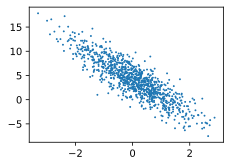

In [12]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [13]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [14]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0303,  1.3393],
        [-0.4066,  1.0040],
        [ 0.9204,  1.6522],
        [-0.0836,  0.5664],
        [-0.4842, -0.3684],
        [-0.3856, -1.4122],
        [ 0.8105,  0.7776],
        [-1.0099, -1.6764],
        [ 1.5127, -0.1066],
        [-0.0310, -1.1703]]) 
 tensor([[-0.3051],
        [-0.0307],
        [ 0.4164],
        [ 2.1165],
        [ 4.4892],
        [ 8.2319],
        [ 3.1619],
        [ 7.8837],
        [ 7.5988],
        [ 8.1343]])


In [15]:
w = torch.normal(0, 0.01, size = (2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [16]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [17]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2

In [18]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [19]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [20]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)

    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000252
epoch 2, loss 0.000108
epoch 3, loss 0.000109


In [21]:
print(f'error in estimating w: {w.reshape(true_w.shape) - true_w}')
print(f'error in estimating b: {b - true_b}')

error in estimating w: tensor([-0.0009, -0.0010], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0006], grad_fn=<SubBackward0>)


# concise implementation of linear regression

In [22]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [23]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [24]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [25]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [26]:
next(iter(data_iter))

[tensor([[-0.2660,  0.0333],
         [ 0.4675, -1.4017],
         [-0.8918, -0.7372],
         [ 0.7645, -1.5892],
         [ 1.1564, -0.1701],
         [ 0.1834,  0.7725],
         [-1.3897,  0.6960],
         [ 0.9340,  0.9151],
         [ 1.0192, -0.1132],
         [ 1.1181, -0.7942]]),
 tensor([[ 3.5544],
         [ 9.8919],
         [ 4.9160],
         [11.1347],
         [ 7.0795],
         [ 1.9407],
         [-0.9387],
         [ 2.9705],
         [ 6.6136],
         [ 9.1330]])]

In [27]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [28]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [29]:
loss = nn.MSELoss()

In [30]:
net.parameters()

<generator object Module.parameters at 0x7fc892915820>

In [31]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [32]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000141
epoch 2, loss 0.000095
epoch 3, loss 0.000094


In [33]:
w = net[0].weight.data
print('error in estimating w: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b: ', true_b - b)

error in estimating w:  tensor([-8.8692e-05, -5.0116e-04])
error in estimating b:  tensor([0.0001])


# Softmax Regression

## cross entropy and information-theory

### https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/information-theory.html

# The image classification dataset

In [34]:
# use Fashion-MNIST dataset
import torch 
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [35]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=trans, download=True)

In [36]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [37]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [38]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [39]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [40]:
# Visualization
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

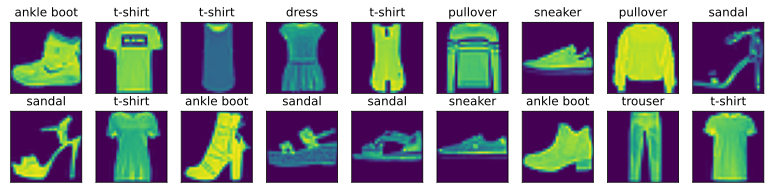

In [41]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [42]:
batchsize = 256

def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [43]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'4.29 sec'

In [44]:
# putting all components together
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()), 
            data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_workers()))

In [45]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X,y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# Implementation of Softmax Regression

In [46]:
import torch
from IPython import display
from d2l import torch as d2l

In [47]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [48]:
# initializing paras
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [49]:
b.shape, W.shape

(torch.Size([10]), torch.Size([784, 10]))

In [50]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [51]:
# validation of softmax
X = torch.normal(0, 1, (2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0173, 0.4391, 0.0855, 0.0497, 0.4083],
         [0.2728, 0.0686, 0.2234, 0.3512, 0.0840]]),
 tensor([1.0000, 1.0000]))

In [52]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

In [53]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [54]:
len(y_hat)

2

In [55]:
# implement the cross-entropy loss function
# L = -Sigma(y * log y_hat)
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [56]:
# classification accuracy
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [57]:
accuracy(y_hat, y) / len(y)

0.5

In [58]:
# compute the accuracy for a model on a dataset
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() # set the model to evaluation mode
    metric = Accumulator(2) # num of correct predictions, num of predictions
    
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [59]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [60]:
evaluate_accuracy(net, test_iter)

0.0725

In [61]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]
    

In [62]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [63]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [64]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W,b], lr, batch_size)

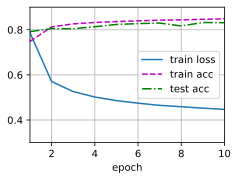

In [65]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

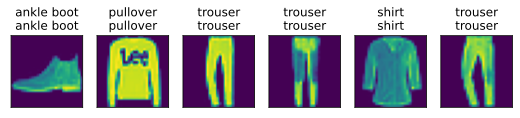

In [67]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)

# Concise implementation of softmax regression

In [68]:
import torch
from torch import nn
from d2l import torch as d2l

In [69]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [70]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10)) # nn.Flatten()---https://www.cnblogs.com/dilthey/p/12376179.html

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [71]:
loss = nn.CrossEntropyLoss()

In [72]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

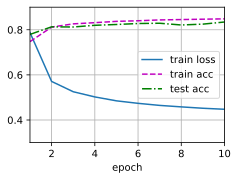

In [73]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)